## Ranking Neural Net

In [1]:
import torch 
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
# import tensorboard
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import pearsonr

In [2]:
class PrismDataset(Dataset):
    def __init__(self, response_df, feature_df, feature_importance_df, top_k_features, slate_length, quantile_transfomer=None, prioritize_sensitive=True):
        self.response_df = response_df
        self.feature_df = feature_df
        self.feature_importance_df = feature_importance_df
        self.top_k_features = top_k_features
        self.slate_length = slate_length
        self.prioritize_sensitive = prioritize_sensitive
        
        # Get the top k features based on importance
        top_features = self.feature_importance_df.nlargest(top_k_features, "importance")["feature"].tolist()

        # filter self.feature_df to include only the top features
        self.feature_df = self.feature_df.loc[:, top_features]

        # quantile transform all features
        if not quantile_transfomer:
            self.quantile_transfomer = QuantileTransformer()
            self.quantile_transfomer.fit(self.feature_df)
        else:
            self.quantile_transfomer = quantile_transfomer

        # quantile transform feature_df
        self.feature_df = pd.DataFrame(self.quantile_transfomer.transform(self.feature_df), columns=self.feature_df.columns, index=self.feature_df.index)

        # quantile transform labels
        self.label_transformer = QuantileTransformer()
        self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df["LFC.cb"].values) 
        if self.prioritize_sensitive:
            self.response_df.loc[:, "LFC.cb"] = 1 - self.response_df["LFC.cb"].values
        # scale from 0 to 5
        self.response_df.loc[:, "LFC.cb"] = self.response_df["LFC.cb"] * 5

        # Join response_df and feature_df on "ccle_name"
        self.joined_df = pd.merge(self.response_df, self.feature_df, on="ccle_name")
        # set index to "ccle_name"
        self.joined_df = self.joined_df.set_index("ccle_name")

        # Order the columns
        self.cols = top_features + ["LFC.cb"]
        self.joined_df = self.joined_df.loc[:, self.cols]

        # impute missing values
        self.joined_df = self.joined_df.fillna(-1)

        # get ccle_names
        self.ccle_names = self.joined_df.index.tolist()

    def __len__(self):
        return len(self.ccle_names)

    def __getitem__(self, idx):
        # get slate_length - 1 samples from ccle_names
        index_name = self.ccle_names[idx]
        ccle_names = np.random.choice(self.ccle_names, self.slate_length - 1, replace=False).tolist()

        # get [index_name, *ccle_names] from joined_df
        samples = self.joined_df.loc[[index_name] + ccle_names, :]
        
        # Extract features and labels from the samples
        features = torch.tensor(samples.iloc[:, :-1].values, dtype=torch.float32)
        labels = torch.tensor(samples.iloc[:, -1].values.squeeze(), dtype=torch.float32)

        return features, labels


In [3]:
feature_path = "../../tests/data/test_features/x-all.pkl"
response_path = "../../tests/data/test_responses.csv"
feature_importance_path = "../../tests/data/test_output/cv/zotarolimus_BRD-K46843573-001-01-9_2.5_all_feature_importances.csv"

In [4]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [5]:
response_df = pd.read_csv(response_path)

In [6]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [7]:
ds = PrismDataset(response_df, feature_df, feature_importance_df, 100, 10)

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(
/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(


In [8]:
ds[0]

(tensor([[0.9409, 0.9004, 0.3672, 0.3657, 0.5168, 0.6693, 0.8165, 0.6327, 0.3661,
          0.0000],
         [0.8586, 0.3663, 0.6827, 0.4754, 0.2586, 0.9758, 0.3660, 0.5204, 0.3175,
          0.0000],
         [0.6135, 0.5871, 0.5905, 0.6130, 0.7132, 0.5128, 0.9091, 0.0000, 0.6345,
          0.0000],
         [0.1197, 0.8061, 0.6125, 0.1224, 0.8823, 0.7035, 0.7604, 0.0000, 0.4753,
          0.0000],
         [0.7177, 0.7069, 0.8403, 0.6861, 0.5043, 0.1411, 0.7535, 0.6327, 0.6620,
          0.8469],
         [0.7467, 0.4143, 0.3719, 0.9290, 0.4290, 0.7229, 0.1613, 0.9639, 0.4490,
          0.0000],
         [0.8186, 0.3433, 0.6537, 0.5249, 0.5528, 0.5488, 0.2741, 0.0000, 0.0000,
          0.0000],
         [0.0732, 0.8945, 0.7290, 0.0435, 0.9141, 0.7934, 0.1239, 0.3367, 0.7728,
          0.0000],
         [0.5701, 0.1400, 0.5197, 0.9168, 0.8602, 1.0000, 0.4756, 0.7653, 0.7012,
          0.0000],
         [0.8832, 0.9511, 0.0892, 0.5710, 0.3162, 0.3061, 0.2572, 0.5204, 0.1376,
         

In [9]:
import torch

PADDED_Y_VALUE = -1
DEFAULT_EPS = 1e-10


def lambdaLoss(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE, weighing_scheme=None, k=None, sigma=1., mu=10.,
               reduction="sum", reduction_log="binary"):
    """
    LambdaLoss framework for LTR losses implementations, introduced in "The LambdaLoss Framework for Ranking Metric Optimization".
    Contains implementations of different weighing schemes corresponding to e.g. LambdaRank or RankNet.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param weighing_scheme: a string corresponding to a name of one of the weighing schemes
    :param k: rank at which the loss is truncated
    :param sigma: score difference weight used in the sigmoid function
    :param mu: optional weight used in NDCGLoss2++ weighing scheme
    :param reduction: losses reduction method, could be either a sum or a mean
    :param reduction_log: logarithm variant used prior to masking and loss reduction, either binary or natural
    :return: loss value, a torch.Tensor
    """
    device = y_pred.device
    y_pred = y_pred.clone()
    y_true = y_true.clone()

    padded_mask = y_true == padded_value_indicator
    y_pred[padded_mask] = float("-inf")
    y_true[padded_mask] = float("-inf")

    # Here we sort the true and predicted relevancy scores.
    y_pred_sorted, indices_pred = y_pred.sort(descending=True, dim=-1)
    y_true_sorted, _ = y_true.sort(descending=True, dim=-1)

    # After sorting, we can mask out the pairs of indices (i, j) containing index of a padded element.
    true_sorted_by_preds = torch.gather(y_true, dim=1, index=indices_pred)
    true_diffs = true_sorted_by_preds[:, :, None] - true_sorted_by_preds[:, None, :]
    padded_pairs_mask = torch.isfinite(true_diffs)

    if weighing_scheme != "ndcgLoss1_scheme":
        padded_pairs_mask = padded_pairs_mask & (true_diffs > 0)

    ndcg_at_k_mask = torch.zeros((y_pred.shape[1], y_pred.shape[1]), dtype=torch.bool, device=device)
    ndcg_at_k_mask[:k, :k] = 1

    # Here we clamp the -infs to get correct gains and ideal DCGs (maxDCGs)
    true_sorted_by_preds.clamp_(min=0.)
    y_true_sorted.clamp_(min=0.)

    # Here we find the gains, discounts and ideal DCGs per slate.
    pos_idxs = torch.arange(1, y_pred.shape[1] + 1).to(device)
    D = torch.log2(1. + pos_idxs.float())[None, :]
    maxDCGs = torch.sum(((torch.pow(2, y_true_sorted) - 1) / D)[:, :k], dim=-1).clamp(min=eps)
    G = (torch.pow(2, true_sorted_by_preds) - 1) / maxDCGs[:, None]

    # Here we apply appropriate weighing scheme - ndcgLoss1, ndcgLoss2, ndcgLoss2++ or no weights (=1.0)
    if weighing_scheme is None:
        weights = 1.
    else:
        weights = globals()[weighing_scheme](G, D, mu, true_sorted_by_preds)  # type: ignore

    # We are clamping the array entries to maintain correct backprop (log(0) and division by 0)
    scores_diffs = (y_pred_sorted[:, :, None] - y_pred_sorted[:, None, :]).clamp(min=-1e8, max=1e8)
    scores_diffs.masked_fill(torch.isnan(scores_diffs), 0.)
    weighted_probas = (torch.sigmoid(sigma * scores_diffs).clamp(min=eps) ** weights).clamp(min=eps)
    if reduction_log == "natural":
        losses = torch.log(weighted_probas)
    elif reduction_log == "binary":
        losses = torch.log2(weighted_probas)
    else:
        raise ValueError("Reduction logarithm base can be either natural or binary")

    if reduction == "sum":
        loss = -torch.sum(losses[padded_pairs_mask & ndcg_at_k_mask])
    elif reduction == "mean":
        loss = -torch.mean(losses[padded_pairs_mask & ndcg_at_k_mask])
    else:
        raise ValueError("Reduction method can be either sum or mean")

    return loss


def ndcgLoss1_scheme(G, D, *args):
    return (G / D)[:, :, None]


def ndcgLoss2_scheme(G, D, *args):
    pos_idxs = torch.arange(1, G.shape[1] + 1, device=G.device)
    delta_idxs = torch.abs(pos_idxs[:, None] - pos_idxs[None, :])
    deltas = torch.abs(torch.pow(torch.abs(D[0, delta_idxs - 1]), -1.) - torch.pow(torch.abs(D[0, delta_idxs]), -1.))
    deltas.diagonal().zero_()

    return deltas[None, :, :] * torch.abs(G[:, :, None] - G[:, None, :])


def lambdaRank_scheme(G, D, *args):
    return torch.abs(torch.pow(D[:, :, None], -1.) - torch.pow(D[:, None, :], -1.)) * torch.abs(G[:, :, None] - G[:, None, :])


def ndcgLoss2PP_scheme(G, D, *args):
    return args[0] * ndcgLoss2_scheme(G, D) + lambdaRank_scheme(G, D)


def rankNet_scheme(G, D, *args):
    return 1.


def rankNetWeightedByGTDiff_scheme(G, D, *args):
    return torch.abs(args[1][:, :, None] - args[1][:, None, :])


def rankNetWeightedByGTDiffPowed_scheme(G, D, *args):
    return torch.abs(torch.pow(args[1][:, :, None], 2) - torch.pow(args[1][:, None, :], 2))

In [10]:
import torch
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x).squeeze(-1)
        return x


In [11]:
model = FeedForwardNet(10)

In [12]:
# create a torch dataloader around the dataset
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=3, shuffle=True)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
for epoch in range(10):
    for batch in dl:
        features, labels = batch
        pred_scores = model(features)
        loss = lambdaLoss(pred_scores, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 88.6083
Epoch [2/10], Loss: 86.9683
Epoch [3/10], Loss: 85.3556
Epoch [4/10], Loss: 75.9421
Epoch [5/10], Loss: 81.6182
Epoch [6/10], Loss: 68.9672
Epoch [7/10], Loss: 89.4421
Epoch [8/10], Loss: 69.9309
Epoch [9/10], Loss: 70.7934
Epoch [10/10], Loss: 65.6689


In [15]:
pred_scores.shape

torch.Size([2, 10])

In [16]:
pred_scores

tensor([[-1.2319,  0.3979, -0.1017, -0.4764,  1.2749, -0.2224, -1.0116, -0.0799,
         -1.5321, -0.7507],
        [-0.4162,  0.3979, -0.5499, -0.1987, -0.9044, -1.2434, -1.5284,  0.4011,
         -1.1768, -1.6927]], grad_fn=<SqueezeBackward1>)

# Now do the same but train on the GPU with real data

In [17]:
feature_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl"
response_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_repurposing/updated_responses/AMG-232.csv"
feature_importance_path = "/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230522_debug_weighted_models/data/baseline_rf/all/AMG-232_BRD-K64925568-001-01-8_2.5_all_feature_importances.csv"

In [18]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [19]:
response_df = pd.read_csv(response_path)

In [20]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
from sklearn.model_selection import KFold

In [23]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# add tensorboard logging


all_preds = []
all_true = []

NUM_FEATURES = 500
SLATE_LENGTH = 100
NUM_EPOCHS = 100

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index]
    response_test = response_df.iloc[test_index]
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features)
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1


/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.
  warnings.warn(
/tmp/ipykernel_22717/3178101372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
/tmp/ipykernel_22717/3178101372.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

Epoch [1/100], Loss: 68.2126
Epoch [2/100], Loss: 29.8384
Epoch [3/100], Loss: 18.4911
Epoch [4/100], Loss: 12.8381
Epoch [5/100], Loss: 9.6359
Epoch [6/100], Loss: 8.0374
Epoch [7/100], Loss: 6.8178
Epoch [8/100], Loss: 5.5281
Epoch [9/100], Loss: 3.9941
Epoch [10/100], Loss: 3.8889
Epoch [11/100], Loss: 3.5647
Epoch [12/100], Loss: 3.3552
Epoch [13/100], Loss: 3.0140
Epoch [14/100], Loss: 2.4296
Epoch [15/100], Loss: 2.1619
Epoch [16/100], Loss: 1.9901
Epoch [17/100], Loss: 1.8804
Epoch [18/100], Loss: 2.0035
Epoch [19/100], Loss: 1.8109
Epoch [20/100], Loss: 1.4795
Epoch [21/100], Loss: 1.6947
Epoch [22/100], Loss: 1.4346
Epoch [23/100], Loss: 1.7753
Epoch [24/100], Loss: 1.8759
Epoch [25/100], Loss: 1.4854
Epoch [26/100], Loss: 1.6473
Epoch [27/100], Loss: 1.7607
Epoch [28/100], Loss: 1.4944
Epoch [29/100], Loss: 1.4619
Epoch [30/100], Loss: 1.6085
Epoch [31/100], Loss: 1.2494
Epoch [32/100], Loss: 1.7362
Epoch [33/100], Loss: 1.0469
Epoch [34/100], Loss: 2.0088
Epoch [35/100], Los

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/tmp/ipykernel_22717/3178101372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
/tmp/ipykernel_22717/3178101372.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

Fold 2


/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.
  warnings.warn(
/tmp/ipykernel_22717/3178101372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
/tmp/ipykernel_22717/3178101372.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

Epoch [1/100], Loss: 50.9072
Epoch [2/100], Loss: 28.0108
Epoch [3/100], Loss: 19.7724
Epoch [4/100], Loss: 15.7181
Epoch [5/100], Loss: 10.2763
Epoch [6/100], Loss: 7.2686
Epoch [7/100], Loss: 7.1058
Epoch [8/100], Loss: 5.4562
Epoch [9/100], Loss: 4.0463
Epoch [10/100], Loss: 4.1316
Epoch [11/100], Loss: 3.3747
Epoch [12/100], Loss: 2.7746
Epoch [13/100], Loss: 2.5453
Epoch [14/100], Loss: 2.5010
Epoch [15/100], Loss: 2.3153
Epoch [16/100], Loss: 2.0934
Epoch [17/100], Loss: 1.8626
Epoch [18/100], Loss: 1.7058
Epoch [19/100], Loss: 1.8041
Epoch [20/100], Loss: 1.8076
Epoch [21/100], Loss: 2.1883
Epoch [22/100], Loss: 1.7762
Epoch [23/100], Loss: 1.9393
Epoch [24/100], Loss: 1.4461
Epoch [25/100], Loss: 1.7778
Epoch [26/100], Loss: 1.5431
Epoch [27/100], Loss: 1.7491
Epoch [28/100], Loss: 1.6144
Epoch [29/100], Loss: 1.3537
Epoch [30/100], Loss: 1.4354
Epoch [31/100], Loss: 1.1964
Epoch [32/100], Loss: 1.2147
Epoch [33/100], Loss: 1.4460
Epoch [34/100], Loss: 1.1760
Epoch [35/100], Lo

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn(
/tmp/ipykernel_22717/3178101372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
/tmp/ipykernel_22717/3178101372.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

Fold 3


/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.
  warnings.warn(
/tmp/ipykernel_22717/3178101372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.response_df.loc[:, "LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
/tmp/ipykernel_22717/3178101372.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

Epoch [1/100], Loss: 75.1052
Epoch [2/100], Loss: 26.9490
Epoch [3/100], Loss: 17.4126
Epoch [4/100], Loss: 14.3117
Epoch [5/100], Loss: 9.4394
Epoch [6/100], Loss: 7.4444
Epoch [7/100], Loss: 5.8792
Epoch [8/100], Loss: 4.8750
Epoch [9/100], Loss: 3.4860
Epoch [10/100], Loss: 3.0895
Epoch [11/100], Loss: 2.3535
Epoch [12/100], Loss: 2.4407
Epoch [13/100], Loss: 1.8300
Epoch [14/100], Loss: 1.9897
Epoch [15/100], Loss: 1.2121
Epoch [16/100], Loss: 1.5844
Epoch [17/100], Loss: 1.7268
Epoch [18/100], Loss: 1.8651
Epoch [19/100], Loss: 2.4250
Epoch [20/100], Loss: 1.2126
Epoch [21/100], Loss: 1.9749
Epoch [22/100], Loss: 1.1486
Epoch [23/100], Loss: 1.0841
Epoch [24/100], Loss: 1.4564
Epoch [25/100], Loss: 1.3698
Epoch [26/100], Loss: 1.0561
Epoch [27/100], Loss: 1.6469
Epoch [28/100], Loss: 1.6518
Epoch [29/100], Loss: 1.6546
Epoch [30/100], Loss: 1.6557
Epoch [31/100], Loss: 1.0668
Epoch [32/100], Loss: 1.2617
Epoch [33/100], Loss: 1.0420
Epoch [34/100], Loss: 0.8740
Epoch [35/100], Los

In [133]:
labels

tensor([[-0.6826, -1.2387, -0.6166, -0.8763, -0.9685, -0.7606, -1.5604, -0.7964,
         -2.3521, -0.8369],
        [-1.2933, -0.7317, -0.6804, -1.4229, -1.0264, -0.7443, -2.3521, -1.1995,
         -0.7000, -0.7034]])

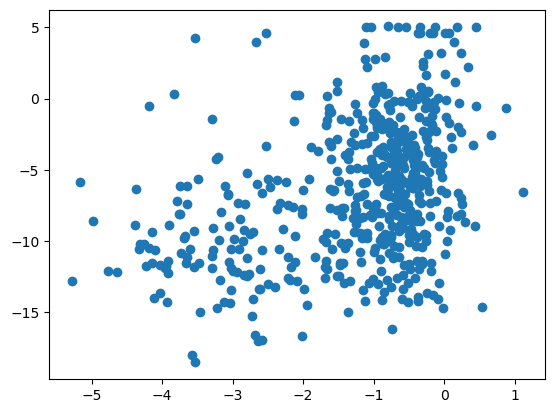

In [ ]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [ ]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.3721174277965609, 9.094770779503158e-20)